# **From stellar stream/DM subhalos encounters to power spectrum: a one way analysis**

# Description

Like the stream_sim_galpy notebook, this notebook is meant to simulate stellar streams formed through star cluster accretion in a host potential, and have the same dependencies, apart from the galpy extension streampepperdf.py which allow the user to perform multiple DMS impact for one stellar stream pdf generation. To use it, the user must DL the python extension at https://gist.github.com/jobovy/1be0be25b525e5f50ea3 and add it to the galpy df folder, update the \_init\_.py file and change:

 "from galpy.util import bovy_conversion, bovy_coords" (because it is deprecated) to\
 "import galpy.util.conversion as bovy_conversion\
  import galpy.util.coords as bovy_coords"

It requires a config files, found in config folder, with particular cluster data (Pal_5 config fle is given as an example). User can create his own sts config file from the custom_config file in the same directory.
It is paired with simulation/data analysis python files found in Codes directory.
It switches beetween ICRS, galactic and (phi1, phi2) coordinate systems, depending of the user specification.

Required libraries to make it work are specified in the README file.

Libraries

In [1]:
###Libraries
#Mains
%matplotlib widget
# %matplotlib inline
import galpy.potential as gp
import galpy.df as gd #for streams PDF generation
import galpy.actionAngle as ga
from galpy.orbit import Orbit

#Utils
from importlib import reload
import pandas as pd
import sys
import yaml
import os
#Define user path
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u
import astropy.coordinates as ac
from astropy.table import Table
# import galpy.util.conversion as guconv
import galpy.util.coords as gucoord
import galpy.util.conversion as guconv
import gala.coordinates as gc #for great circle rotation
with ac.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = ac.Galactocentric()

In [2]:
###Librairires for simulation and 
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities
from galpy.df import streampepperdf #Extension to perform multiple impact
import stream_galsim.impact_distribution as sid; reload(sid)

<module 'stream_galsim.impact_distribution' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/impact_distribution.py'>

# Power spectrum of one stellar stream

The goal here is to compute a power spectrum of a simulated stellar stream, by mimicking as much as we can the properties of an existing stellar stream.

At first we set the properties of the unperturbed system, including a progenitor (usually a globular cluster) and an accreting host in which it is stripped.

## Initialization

In [3]:
##Load progenitor config file
# Path to the yaml config file in the 'config' folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
config_file = 'galstreams_Pal5_config.yaml'
config_path = os.path.join(base_dir, 'config', config_file)

# Load YAML and convert it to a DataFrame
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)

##Display cluster data
#current pose/velocity in ICRS
stream_data = pd.DataFrame(config_data)
# print(stream_data)
#only progenitor data is wanted for our simulation
progenitor = stream_data[4:].loc[:,["cluster","ra","dec","distance","pm_ra_cosdec","pm_dec","radial_velocity"]]
#["dec","dec_unit","distance","distance_unit","frame","pm_dec","pm_dec_unit","pm_ra_cosdec","pm_ra_cosdec_unit", "ra","ra_unit","radial_velocity","radial_velocity_unit"]
print(progenitor.values.tolist()[0])

['Pal5', 229.0, -0.124, 22.9, -2.296, -2.257, -58.7]


In [4]:
###Progenitor
#progenitor coord 
cluster_name = progenitor.values.tolist()[0][0] #name
prog_orbit = Orbit(progenitor.values.tolist()[0][1:], radec=True) #progenitor orbit instance. radec=True specify the frame used radec=ICRS


prog_mass = 2*10.**4.*u.Msun
prog_a = 20.*u.pc #scale radius of the plummer sphere
rc = 23*u.pc #progenitor radius
prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
prog_sigv = 0.365 *u.km/u.s
t_disrupt = 4.5*u.Gyr #time of disruption of cluster, typically 4.5Gyr
# tdisrupt= guc.time_in_Gyr(V0,R0)

In [5]:
###Accreting host
### Usually Milky way potential
V0, R0= 245.6, 8.122 #scale parameters
vsun=[-12.9,245.6,7.78] #for streamdf, vxyz
mw_pot = gp.MWPotential2014
aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=0.8)

Simulating the unperturbed model

In [6]:
#NonPerturbedStreamModel class from sid
np.random.seed(4)
SmoothStreamdf = sid.NonPerturbedStreamModel(sigv = prog_sigv,
            progenitor=prog_orbit,
            pot=mw_pot,
            aA=aaisochrone,
            leading=True,
            ro = R0, #Distance scale for translation into internal units
            vsun=vsun,
            tdisrupt=t_disrupt)

In [7]:
###Retrieve significant data from unperturbed streamdf
smooth_length = SmoothStreamdf.stream_length()
r_avg, r_max = SmoothStreamdf.compute_r_avg_max()
d_omega_par = SmoothStreamdf.compute_average_Omega_parallel()
# d_omega_par = SmoothStreamdf.estimate_Omega_parallel()
print(r_avg, r_max, d_omega_par,t_disrupt)


15.879295627829713 18.769286680719258 1.0500180297207204 4.5 Gyr


In [8]:
sdf = SmoothStreamdf.streamdf()

## Statistical sampling of a DM subhalos distribution

We want to align the simulation as closely as possible with real astrophysical data. Therefore, it is necessary to define a realistic environment for creating a disturbed flow. We already have the progenitor and an accreting host, but we do not have a precise distribution of the DMS in the latter. 

- At first we sample a distribution of subhalos for the considered galactical/cosmological model (DMS_distribution class). 
- Then we compute an expected number of encounters within the stellar stream and the subhalos (N_encounter function). 
- Finally, we sample the distribution of impact parameters, considering the DMS distribution and the smooth stream model computed already.


Considered properties and parameters in the model:
- the impact time ti;
- the angle parallel to the flow at which the impact occurs at the time of closest approach;
- the flyby velocity of the dark matter halo;
- the impact parameter;
- the intrinsic properties of the subhalo (mass, density profile, and radius).
- the mass range considered (Mmin,Mmax)


In [9]:
#DMS_Distribution class from sid
### Tests on Nenc
Mmin, Mmax = 1e5, 1e9
sigma_h = 150*u.km/u.s
dms = sid.DMS_Distribution()
bmax = dms.bmax_inmassrange(Mmin, Mmax, profile='NFW', alpha=5)
print(f"{bmax:.2f}")

n_h = dms.density_involume_inmassrange(r_max, Mmin, Mmax)
N_h = dms.number_involume_inmassrange(r_max, Mmin, Mmax)
print(f"{n_h}", f"{N_h:.1f}")


0.12 kpc
0.013922867542613022 1 / kpc3 385.6


In [10]:
#N_encounter from sid
N_enc = sid.expected_N_encounters(r_avg=r_avg, sigma_h=sigma_h, t_d=t_disrupt, delta_omega=d_omega_par, b_max=bmax, n_h=n_h)
print(N_enc)

78.54467427246766 rad


Generating 7 impacts between the stream and subhalos
t,theta,m,b, w[0], w[1], w[2]]
[[ 2.09906639e+00  3.51629224e+00  1.23243410e+00  3.76641484e+00
   2.34979085e+00  3.92236926e+00  3.27079127e+00]
 [ 2.47954161e-01  8.82211961e-01  3.96684110e-01  1.40109643e+00
   5.70654780e-01  1.36597748e+00  7.69561375e-01]
 [ 4.81159310e+05  1.28766070e+06  1.99686376e+05  5.05014067e+05
   1.48225595e+05  1.13661532e+05  1.07123972e+06]
 [ 3.64169651e-01  5.95744475e-01  2.34602978e-01  3.73087794e-01
   2.02125406e-01  1.76997062e-01  5.43378733e-01]
 [ 5.54094776e+01  4.49675106e+02  2.28353408e+02  1.06012798e+02
   1.30585766e+02  1.28699575e+02  3.15241131e+02]
 [ 3.77021066e+02 -6.15992748e+01 -2.06740419e+01 -1.16396506e+02
  -9.40516856e+01 -8.77716254e+01 -1.18831357e+02]
 [-7.25978799e+01 -1.96514964e+01 -2.24819669e+02 -1.48216102e+02
  -5.70852466e+01 -1.57280786e+02  1.60654899e+02]]


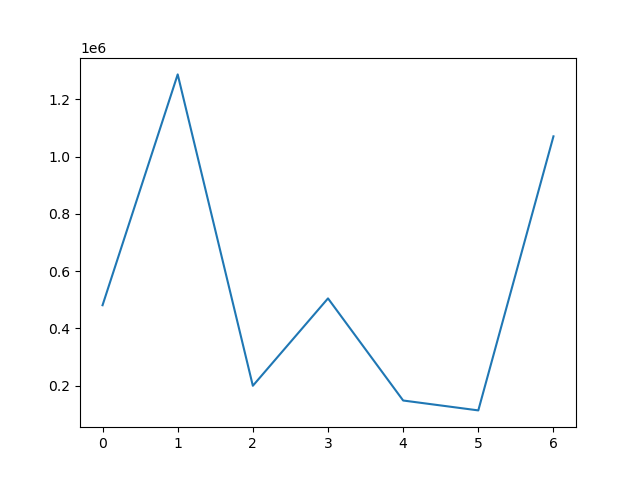

In [11]:
#ImpactSampler class from sid
mass_range = (Mmin,Mmax)*u.Msun
SIS = sid.ImpactSampler(5, mass_range, sigma_h, tdisrupt=t_disrupt, stream_length=smooth_length)
impact_list = SIS.impact_list()

print(impact_list.T)
plt.figure()
plt.plot(impact_list.T[2])
plt.show()

## Simulation of the peppered stream df

Now that we have a physical distribution of impacts, we can simulate those impact onto the smooth stream df.

In [12]:
###Progenitor
#progenitor coord 
cluster_name = progenitor.values.tolist()[0][0] #name
prog_orbit = Orbit(progenitor.values.tolist()[0][1:], radec=True) #progenitor orbit instance. radec=True specify the frame used radec=ICRS


prog_mass = 2*10.**4.*u.Msun
prog_a = 20.*u.pc #scale radius of the plummer sphere
rc = 23*u.pc #progenitor radius
prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
prog_sigv = 0.365 *u.km/u.s
t_disrupt = 4.5*u.Gyr #time of disruption of cluster, typically 4.5Gyr

###Accreting host
### Usually Milky way potential
V0, R0= 245.6*u.km/u.s, 8.122*u.kpc #scale parameters
vsun=[-12.9,245.6,7.78]*u.km/u.s #for streamdf, vxyz
mw_pot = gp.MWPotential2014
aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=0.8)

In [13]:
spdf = streampepperdf(
    sigv=prog_sigv,
    progenitor=prog_orbit,
    pot=mw_pot,
    aA=aaisochrone,
    leading=True,
    tdisrupt=t_disrupt,
    nTrackChunks=26,
    ro=R0,
    vsun=vsun,
    timpact=impact_list.T[0],  # en Gyr
    # impact_angle=[0.1, 0.5],  # en radians
    impactb=impact_list.T[3],  # en kpc
    GM=impact_list.T[2]*6.67*10e-11,  # GM en unités galpy
    rs=impact_list.T[3]/5  # rs en unités galpy
)

In [19]:
def sample_galactocentric(df, perturbed = True, n=1000):
    """
    Sample stars and convert to configuration space.
    """
    if perturbed:
        #Sample actions-angles
        freqs, angles, _ = df._sample_aAt(n)
        #convert
        coords = df._approxaAInv(freqs[0],freqs[1],freqs[2], angles[0],angles[1],angles[2]) #from aA space to cyl
        coords = np.array(gucoord.cyl_to_rect(coords[0],coords[1],coords[2]))
    else:
        coords = df.sample(n, xy=True)
    return coords

In [20]:
from galpy.util import conversion
import numpy as np

def sample_xyz(self, n=1000):
    """
    Retourne les coordonnées Galactocentriques cartésiennes (X, Y, Z) en kpc
    pour n étoiles du stream perturbé.

    Returns
    -------
    xyz : np.ndarray, shape (n, 3)
        Colonnes : X, Y, Z en kpc
    """
    Om, angle, _ = self._sample_aAt(n)
    ro = self._ro
    vo = self._vo
    
    # Convertir (Omega, angle) → (R, vR, vT, z, vz, phi)
    RvR = self._approxaAInv(
        Om[0], Om[1], Om[2],
        angle[0], angle[1], angle[2]
    )
    
    R = RvR[0] * ro
    phi = RvR[5]
    Z = RvR[3] * ro

    X = R * np.cos(phi)
    Y = R * np.sin(phi)

    return np.vstack((X, Y, Z)).T  # shape (n, 3)


In [21]:
sample_xyz
np.random.seed(4)
pstars = sample_xyz(spdf, n=1000)

In [22]:
np.random.seed(4)
stars = sample_galactocentric(sdf, perturbed = False, n=1000)*R0
print(stars)

[[-7.40795724 -7.75376558 -6.43835191 ... -7.45358189 -7.97508551
  -5.16918709]
 [-1.1500294  -0.47787678 -3.05977291 ... -1.10373696  0.10985319
  -4.8669458 ]
 [16.14830949 16.29243526 15.20726025 ... 16.20295667 16.4252298
  13.4455842 ]
 [ 1.98046738  1.80894158  2.45022426 ...  1.9468398   1.65571264
   2.91474385]
 [-4.29807914 -4.30944803 -4.17215525 ... -4.30794497 -4.30621522
  -3.86109024]
 [-1.4588022  -1.02799466 -2.6812022  ... -1.42597272 -0.68520824
  -4.12704787]] kpc


In [23]:
### sampled stars positions
#Extract positions from sampled stars, in xyz galactocentric
X_ps, Y_ps, Z_ps = np.array(stars[:3])* u.kpc# apply np.array()* u.kpc if needed
X_ps = -X_ps #galpy use lefthanded frame, we use righthanded x-> -x
#apply cartesian galactocentric frame to these positions

with ac.galactocentric_frame_defaults.set("v4.0"):  # Use latest MW parameters
    galcen_ps = ac.Galactocentric(x=X_ps, y=Y_ps, z=Z_ps)

#convert galcen into icrs (as seen from observer)
icrs_ps = galcen_ps.transform_to(ac.ICRS())

ra_ps, dec_ps, dist_ps = icrs_ps.T.ra.degree, icrs_ps.T.dec.degree, icrs_ps.T.distance.kpc #ra,dec,distance

(7.86390455, 0.22748727, 16.41622487) kpc


Text(0, 0.5, 'Y')

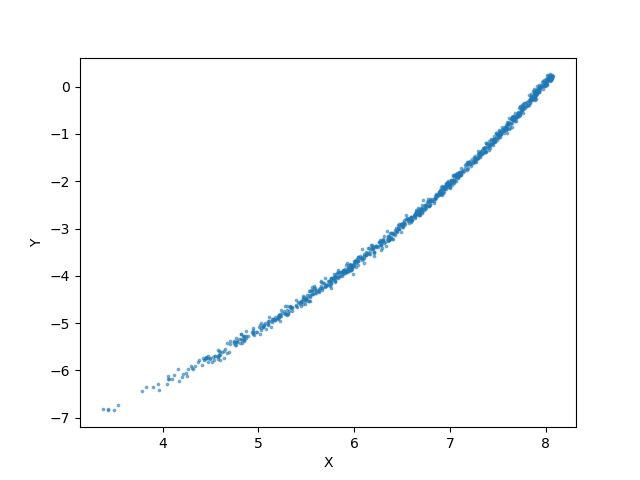

In [24]:
#3D representation
#Cluster, local background potential
c = ac.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
c_gc = c.transform_to(galcen_frame)
print(c_gc.cartesian)
fig2 = plt.figure()
ax2 = fig2.add_subplot()

ax2.scatter(X_ps, Y_ps, alpha=0.5, s=3)#sts
# ax2.scatter(c_gc.cartesian.x,c_gc.cartesian.y,s=100)#progenitor
# ax2.scatter(0,0)#galatic center

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
# ax2.set_zlabel('Z')